# Spending forcasting with XGBoost

Here we will use the `XGBoost` gradient boost regression model

- Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

- Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

- Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network.

- Extreme Gradient Boosting, or XGBoost for short, is an efficient open-source implementation of the gradient boosting algorithm. As such, XGBoost is an algorithm, an open-source project, and a Python library.

- It was initially developed by Tianqi Chen and was described by Chen and Carlos Guestrin in their 2016 paper titled “XGBoost: A Scalable Tree Boosting System.”

- It is designed to be both computationally efficient (e.g. fast to execute) and highly effective, perhaps more effective than other open-source implementations.

- The two main reasons to use XGBoost are execution speed and model performance.

- XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems. The evidence is that it is the go-to algorithm for competition winners on the Kaggle competitive data science platform.

*[information from Machine Learning Mastery.com](https://machinelearningmastery.com/xgboost-for-regression/#:~:text=XGBoost%20is%20an%20efficient%20implementation,a%20prediction%20on%20new%20data.)*

# Import Libraries and Data
we will use the data that has summed all the transactions on each day.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns 

import xgboost as xgb

from sklearn.metrics import mean_squared_error

# colours for seaborn.
color_pal = sns.color_palette()

In [2]:
# import data
# Load the daily database   
with open('./pkl_data/bristol_spending_data_daily.pkl', 'rb') as pickle_file:
    df = pickle.load(pickle_file)

# check data

Check the data import has worked correctly and then plot

In [3]:
df.head()

,Pay Date,Amount
0,2010-08-01,47819035.83
1,2010-08-02,0.00
2,2010-08-03,0.00
3,2010-08-04,0.00
4,2010-08-05,0.00


In [4]:
df = df.set_index('Pay Date')

# lets convert the spending to millions for readability
df['Amount'] = df['Amount'].apply(lambda x: x / 1000000)

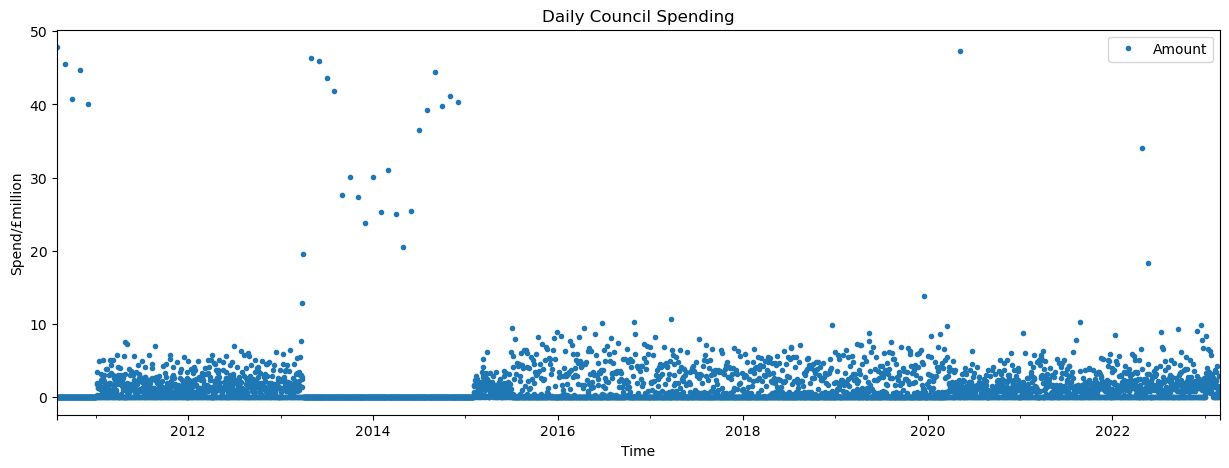

In [5]:
ax = df.plot(style='.',
             figsize=(15, 5),
             color=color_pal[0],
             title='Daily Council Spending')
ax.set_xlabel('Time')
ax.set_ylabel('Spend/£million')

plt.show()

We can see that the daily data is skewed between 2013-2015 as we only have transaction dates by month rather than by day. e.g all the transactions for each month are coming on one day. 

Lets begin by building a model using data after 2015. We could go back and average out the monthly data to use it later.

# Building a model from post 2015 data

In [6]:
# delete all the data before 2015
df = df[df.index >= '2015-01-01']

df.head()

,Amount
Pay Date,
2015-01-01,0.0
2015-01-02,0.0
2015-01-03,0.0
2015-01-04,0.0
2015-01-05,0.0


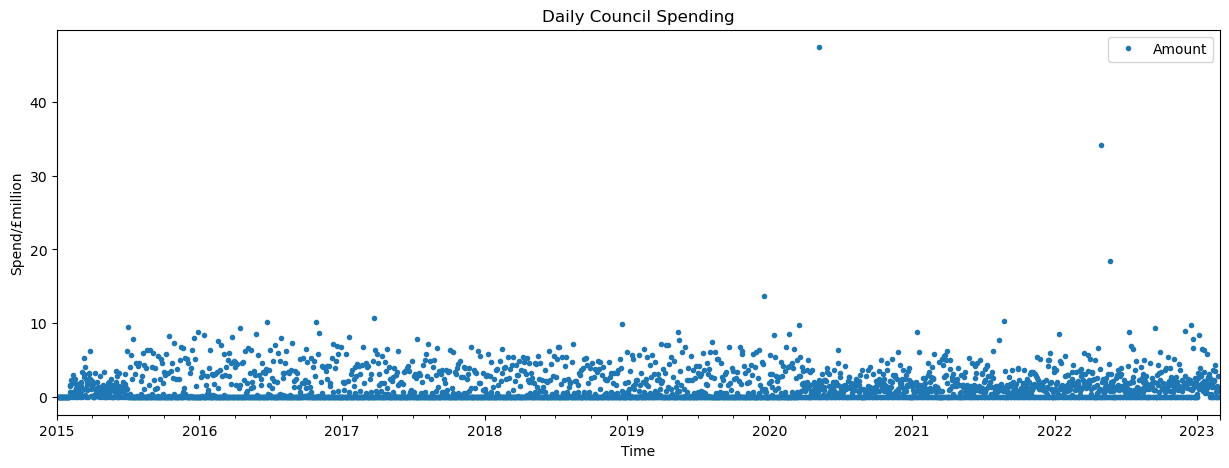

In [7]:
ax = df.plot(style='.',
             figsize=(15, 5),
             color=color_pal[0],
             title='Daily Council Spending')
ax.set_xlabel('Time')
ax.set_ylabel('Spend/£million')

plt.show()

## Time series cross validation

- In the case of time series, the cross-validation is not trivial. We cannot choose random samples and assign them to either the test set or the train set because it makes no sense to use the values from the future to forecast values in the past. In simple word we want to avoid future-looking when we train our model. There is a temporal dependency between observations, and we must preserve that relation during testing.

**Cross Validation on Time Series:**

- The method that can be used for cross-validating the time-series model is cross-validation on a rolling basis. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

- Luckily `sklearn` has a library to create train test splits on time series data.



In [8]:
from sklearn.model_selection import TimeSeriesSplit

# set up parameters for the time series split. The test size is set to 365 as that will give us one year.
# the gap sets a gap between the training and testing sets. We will set this to 1 day.
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

### Visualise the time series cross validation splits.

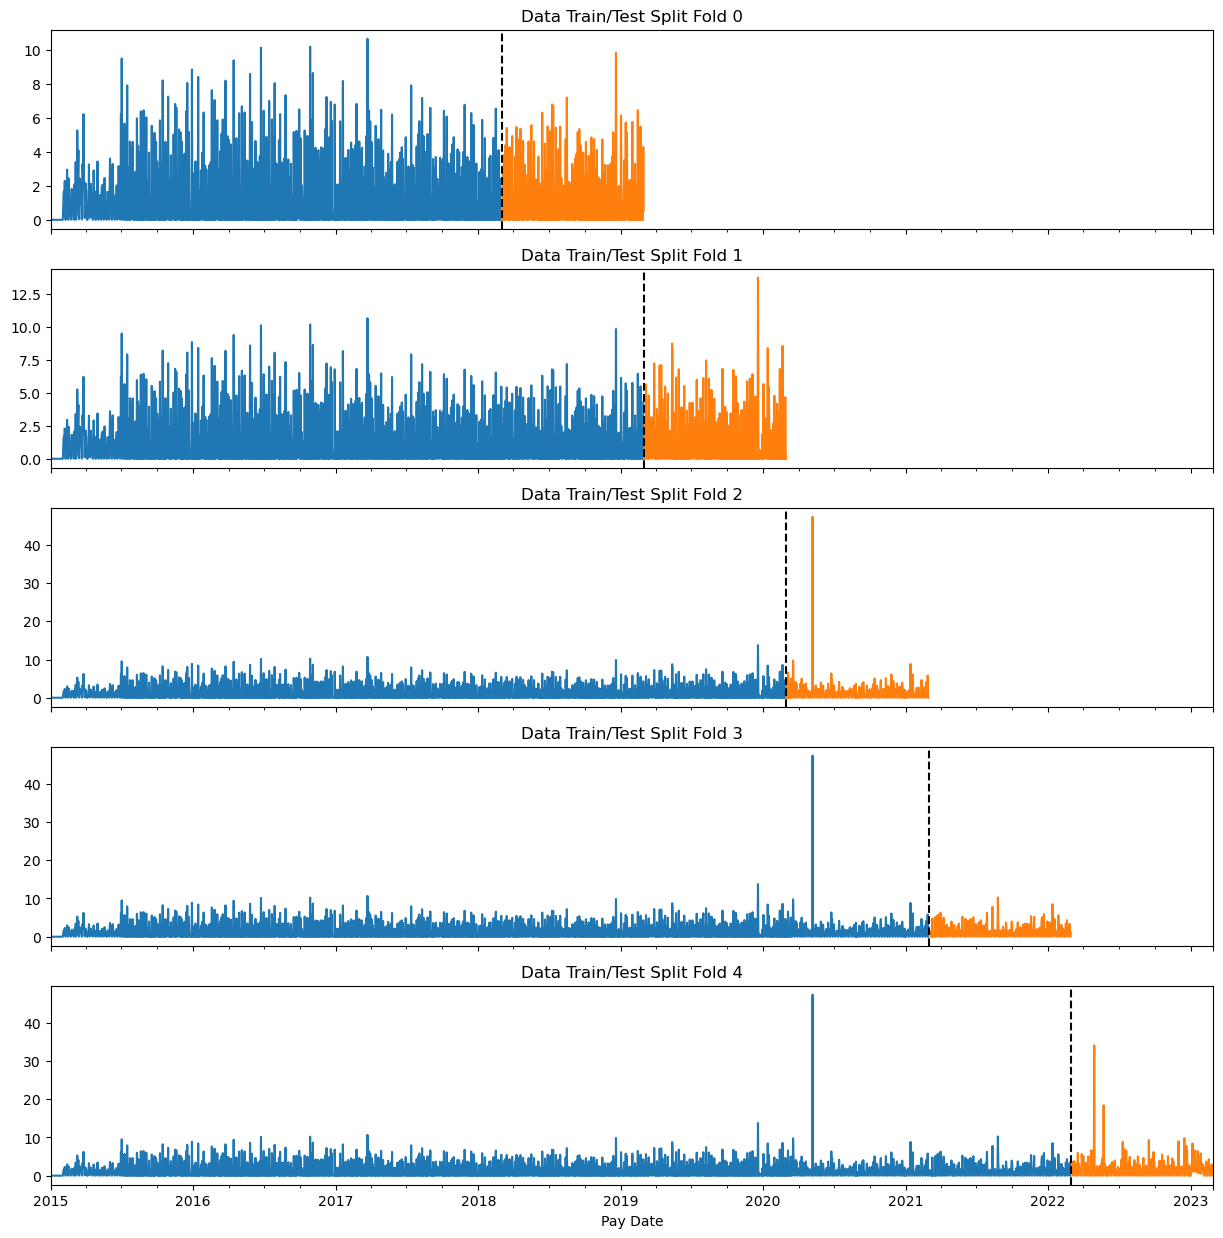

In [9]:
# here we set up and plot the different training and testing splits

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Amount'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Amount'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Create features
- We need to create features to train out model on.

- Here we define a function to create features from the data.  Pandas helps us out here as we can use `df.index.dayofweek` etc to grab components of the datetime found in the index.

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df.head()

,Amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Pay Date,,,,,,,,
2015-01-01,0.0,3,1,1,2015,1,1,1
2015-01-02,0.0,4,1,1,2015,2,2,1
2015-01-03,0.0,5,1,1,2015,3,3,1
2015-01-04,0.0,6,1,1,2015,4,4,1
2015-01-05,0.0,0,1,1,2015,5,5,2


## Lag Features

Lag features are values at prior timesteps that are considered useful because they are created on the assumption that what happened in the past can influence or contain a sort of intrinsic information about the future. 

- For instance, we could compare a days value with the same day in the previous year.


*Note: The time given to the lag features limits the distance you can predict into the future. I have set lag to to one year ago so we will only be able to predict one year into the future.*

*HINT: We use 364 days ago in the lag features beacuse 364 is divisible by 7, so it will give us the same day of the week one year ago.*

In [11]:
# define a funtion to create lag features.

def add_lags(df):
    """
    Create lag features that are 1, 2 and 3 years in the past.
    """
    target_map = df['Amount'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [12]:
df = add_lags(df)
df.tail()

,Amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Pay Date,,,,,,,,,,,
2023-02-24,2.921319,4,1,2,2023,55,24,8,3.369985,5.800062,0.707261
2023-02-25,0.000000,5,1,2,2023,56,25,8,0.000000,0.000000,0.000000
2023-02-26,0.000000,6,1,2,2023,57,26,8,0.000000,0.000000,0.000000
2023-02-27,0.781278,0,1,2,2023,58,27,9,1.058770,1.508984,4.002722
2023-02-28,0.926546,1,1,2,2023,59,28,9,1.486011,1.141895,0.001898


### Visualise the Feature/Target Relationship

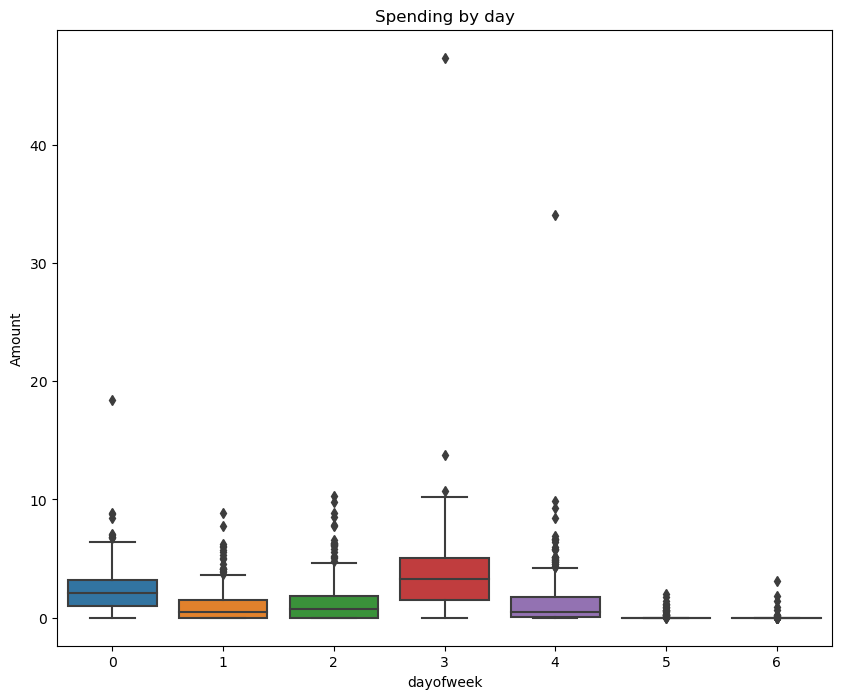

In [13]:
# visualise the spending on each day of the week for the dataset.

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='Amount')
ax.set_title('Spending by day')
plt.show()

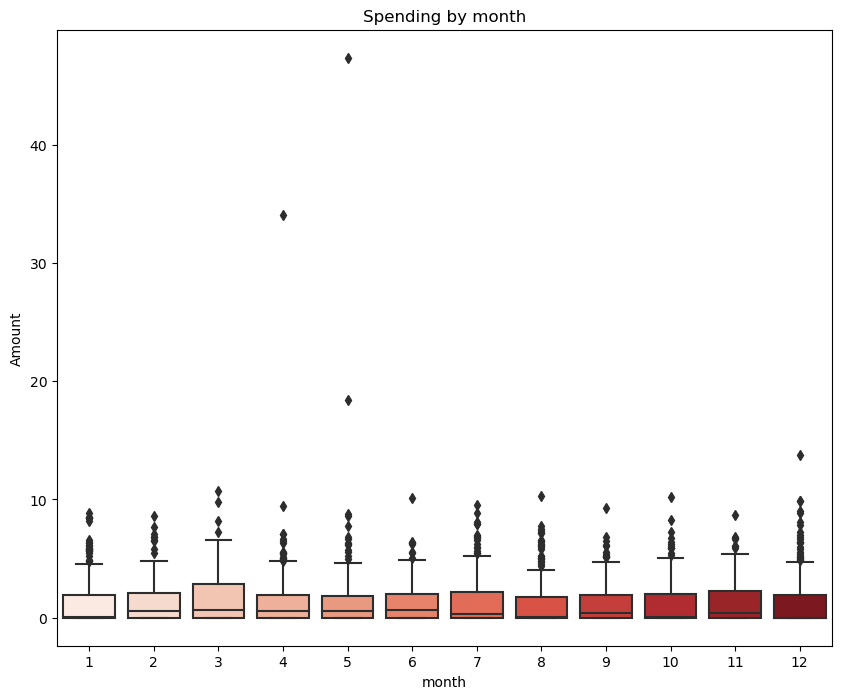

In [14]:
# visualise the spending on each month of the year

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Amount', palette='Reds')
ax.set_title('Spending by month')
plt.show()

## Train the Model Using Cross Validation
Here we will use the `XGBoost` gradient boost regression model.



[12:38:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.11392	validation_1-rmse:1.92310
[100]	validation_0-rmse:1.44511	validation_1-rmse:1.10644
[200]	validation_0-rmse:1.26588	validation_1-rmse:0.99648
[300]	validation_0-rmse:1.20934	validation_1-rmse:0.99274
[308]	validation_0-rmse:1.20671	validation_1-rmse:0.99254
[12:38:35] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.07396	validation_1-rmse:2.24610
[100]	validation_0-rmse:1.38726	validation_1-rmse:1.42409
[200]	validation_0-rmse:1.21835	validation_1-rmse:1.28075
[300]	validation_0-rmse:1.16463	validation_1-rmse:1.25587
[400]	validation_0-rmse:1.13940	validation_1

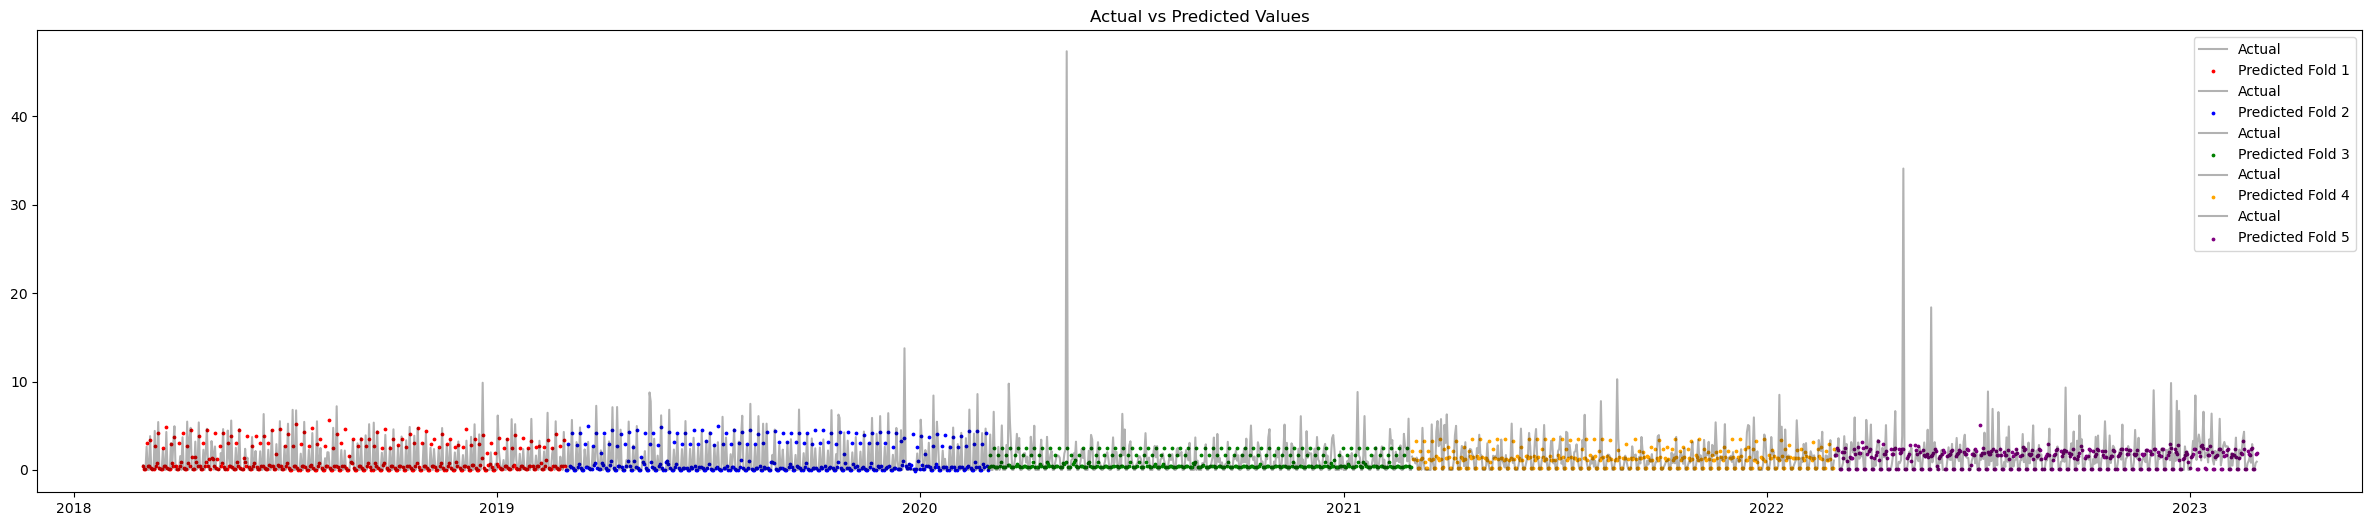

In [15]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
df = df.sort_index()

fold = 0
preds = [] # a list to store the predictions.
scores = [] # a list to store the scores of the predictions.

# Variables used to plot the data
# Colours for each fold
colors = ['red', 'blue', 'green', 'orange', 'purple']
# Create a new figure with a larger size
plt.figure(figsize=(30, 6))

for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]

        train = create_features(train)
        test = create_features(test)

        FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                    'lag1','lag2','lag3']
        TARGET = 'Amount'

        X_train = train[FEATURES] # the features from the training dataset
        y_train = train[TARGET] # the target from the training dataset

        X_test = test[FEATURES] # the features from the testing dataset
        y_test = test[TARGET] # the target from the testing dataset


        # this is the model, we have chosen the regressor from XGBoost.         
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                n_estimators=1000,
                                early_stopping_rounds=50,
                                objective='reg:linear',
                                max_depth=3,
                                learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)
                # verbose just makes it only print after a certain number of trees (100 in this case)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)

        # Plotting the predicted values against the actual values for each fold
        

        plt.plot(y_test.index, y_test.values, label='Actual', c='black', alpha=0.3)
        plt.scatter(y_test.index, y_pred, label=f'Predicted Fold {fold+1}', s=3, c=colors[fold])

        fold += 1

plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

### A summary of the errors from each fold

In [16]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.8056
Fold scores:[0.9899763962378962, 1.2361232326309353, 2.8435713443507424, 1.545526353206009, 2.413001136175139]


## Feature importance

* Usefully, `XGBoost` has a way of showing us the realtive importance of each feature in the model using `reg.feature_importances_`
* These values are based on how many times each feature was used in the trees built by the model.

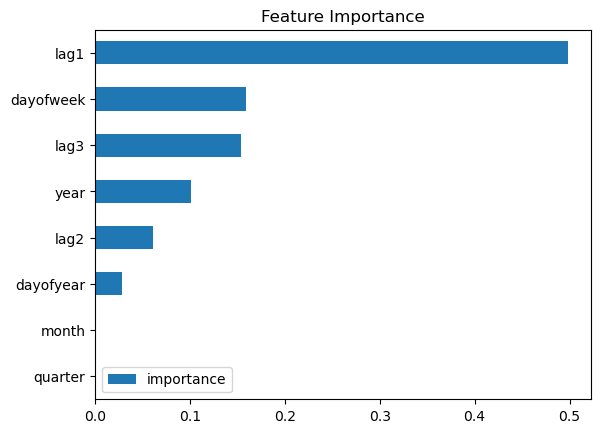

In [17]:
# make a dataframe so we visualise the imortance of each feature
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

This shows us that the most used feature is actually the same day one year ago (`lag1`)

## Predict the future

We can now use the model to predict future spending.

### Retrain the model on all the data
Before predicting, we want to use all the data available to train the model.

In [18]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'Amount'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=400, # from looking at the cross validation, this is about where the model starts to overfit
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:38:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.30884
[100]	validation_0-rmse:1.81424
[200]	validation_0-rmse:1.67884
[300]	validation_0-rmse:1.60857
[399]	validation_0-rmse:1.50615


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [19]:
# find the final date in the dataset so we can start predicting from then.
df.index.max()

Timestamp('2023-02-28 00:00:00')

In [20]:
# Create future dataframe starting from the last date in the data.

# this pandas function creates a list of dates. you can change the start date, end date, frequency etc. 
# default is daily frequency, which is what we want.
future = pd.date_range('2023-02-28','2024-02-01')
future_df = pd.DataFrame(index=future)

# create columns in the dataframes so it is easy to see if a date is in the prediction period (future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [21]:
df_and_future.head()

,Amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2015-01-01,0.0,3,1,1,2015,1,1,1,NaN,NaN,NaN,False
2015-01-02,0.0,4,1,1,2015,2,2,1,NaN,NaN,NaN,False
2015-01-03,0.0,5,1,1,2015,3,3,1,NaN,NaN,NaN,False
2015-01-04,0.0,6,1,1,2015,4,4,1,NaN,NaN,NaN,False
2015-01-05,0.0,0,1,1,2015,5,5,2,NaN,NaN,NaN,False


In [23]:
future_w_features = df_and_future.query('isFuture').copy()

future_w_features

,Amount,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2023-02-28,NaN,1,1,2,2023,59,28,9,1.486011,1.141895,0.001898,True
2023-03-01,NaN,2,1,3,2023,60,1,9,2.191399,1.197626,0.000000,True
2023-03-02,NaN,3,1,3,2023,61,2,9,1.837816,0.731279,6.580767,True
2023-03-03,NaN,4,1,3,2023,62,3,9,3.586688,1.391334,0.189364,True
2023-03-04,NaN,5,1,3,2023,63,4,9,0.062848,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-28,NaN,6,1,1,2024,28,28,4,1.381458,0.000000,0.000000,True
2024-01-29,NaN,0,1,1,2024,29,29,5,2.732108,1.383872,1.316033,True
2024-01-30,NaN,1,1,1,2024,30,30,5,3.162059,0.879793,1.868273,True
2024-01-31,NaN,2,1,1,2024,31,31,5,2.627262,2.941151,2.653941,True


### Fill the dataframe with future predictions.

In [24]:
# create a new column in the dataframe with the predictions from the model.
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

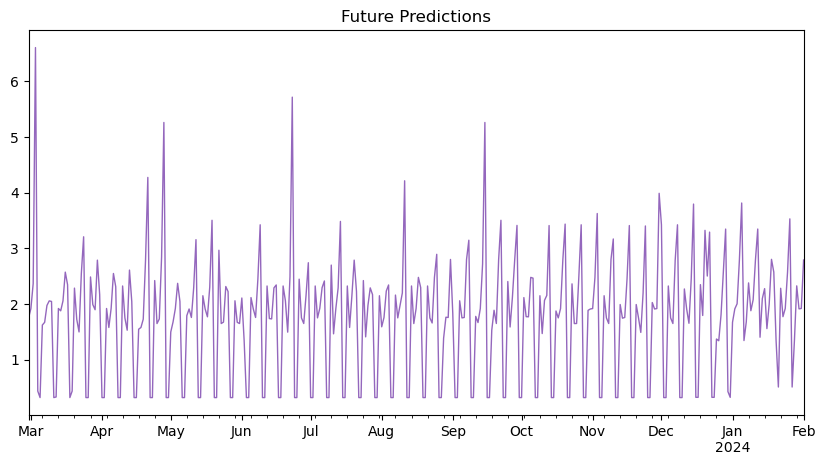

In [25]:
# plot these future predictions

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')

# save the model

In [29]:
# you can save xgboost models using an inbuilt funtion

# Save model
reg.save_model('./models/spending_prediction_model.json')

In [ ]:
# how to load a model

reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

# Further Steps

The model clearly works but is far from super accurate. We could do a few things to improve it:

- We could tune the hyerparameters to improve the model. Things like learning rate, number of trees, size of trees etc.

- We could add more features for special days, e.g. holidays, xmas, pandemic spending etc.

- We could train a model with monthly data so we can use the earlier data which only had transactions dated by month.